In [10]:
!pip install --upgrade datahabit

  Attempting uninstall: datahabit
    Found existing installation: datahabit 0.1.0
    Uninstalling datahabit-0.1.0:
      Successfully uninstalled datahabit-0.1.0


In [1]:
import pandas as pd
from datahabit import (
    TaskData, DataCleaner, BehaviorAnalyzer, Visualizer,
    DeadlinePredictor, PatternDetector, DifficultyEstimator,
    HabitScore, ReportGenerator
)

In [2]:
import sys
sys.path.append('../src/')

df = pd.read_csv('../datasets/ds2b_data.csv')
df.head()


,student,student_id,study_hours,sleep_hours,task_completed,distractions_count,day,start_time,end_time,productivity_score,...,start,due_date,submission_time,week,consistency,breaks_taken,average_focus_minutes,Duration (hrs),complexity,energy_required
0,Aira Grettel Dahe,2024245901,7.0,4,3,3,Wednesday,8:30,15:00,82,...,11/7/2025,2025-12-13 10:00:00,2025-12-13 9:00:00,2,88,4,52,7,High,High
1,Armisty Genia Java,2024300450,3.0,5,3,2,Monday,13:10,18:00,78,...,12/8/2025,2025-12-10 23:59:00,2025-12-12 5:25:00,2,85,3,48,5,Medium,Medium
2,Carmel Marianne Hayag,2024300972,5.0,7,2,5,Thursday,12:00,17:00,70,...,11/3/2025,2025-12-14 14:00:00,2025-12-10 11:50:00,3,80,6,44,5,High,High
3,Karylle Dellosa,2024300111,4.0,5,3,5,Tuesday,10:00,14:00,72,...,11/20/2025,2025-12-04 22:00:00,2025-11-30 23:00:00,3,78,5,45,4,High,High
4,Rodney Trillo,2024161301,NaN,8,1,7,Friday,19:00,21:00,56,...,12/3/2025,2025-12-08 8:30:00,2025-12-10 8:00:00,4,60,7,38,2,High,Medium


In [3]:
df.columns

Index(['student', 'student_id', 'study_hours', 'sleep_hours', 'task_completed',
       'distractions_count', 'day', 'start_time', 'end_time',
       'productivity_score', 'task_name', 'start', 'due_date',
       'submission_time', 'week', 'consistency', 'breaks_taken',
       'average_focus_minutes', 'Duration (hrs)', 'complexity',
       'energy_required'],
      dtype='object')

In [4]:
tasks = []

for _, row in df.iterrows():
    try:
        td = TaskData(
            row["student_id"],
            row["task_name"],
            row["submission_time"]
        )
        tasks.append(td)
    except Exception as e:
        print("Skipped row due to error:", e)

len(tasks)


19

In [5]:
ba = BehaviorAnalyzer(tasks)

label = ba.classify_behavior(df["due_date"].iloc[0])
stats = ba.get_statistics()

label, stats


('Early Finisher',
 {'tasks_analyzed': 19,
  'avg_delay_hours': -61.41754385964912,
  'std_dev_delay': 145.84868178212255,
  'behavior_label': 'Early Finisher'})

In [6]:
pattern = PatternDetector()

for _, row in df.iterrows():
    try:
        clean_time = DataCleaner.parse_timestamp(row["submission_time"])
        pattern.add_submission(clean_time)
    except Exception as e:
        print("Skipped row:", e)

pattern_result = pattern.detect_pattern()
pattern_result



'Morning Worker'

In [8]:
predictor = DeadlinePredictor()

for t in tasks:
    predictor.add_delay(t.get_delay(df["due_date"].iloc[0]))

predicted_delay = predictor.predict_next_delay()
predicted_delay


-61.41754385964912

In [9]:
difficulty = DifficultyEstimator()

for t in tasks:
    difficulty.record_task(t._task_name, t.get_delay(df["due_date"].iloc[0]))

difficulty.get_difficult_tasks()


[('Data Visualization', 180.0),
 ('Machine Learning Project', 171.0),
 ('HCI PIT', 67.0)]

In [10]:
score = HabitScore()

for t in tasks:
    score.add_delay(t.get_delay(df["due_date"].iloc[0]))

final_score = score.compute_score()
final_score


100

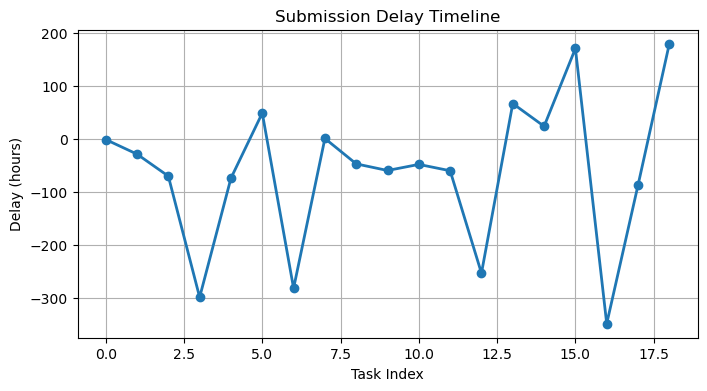

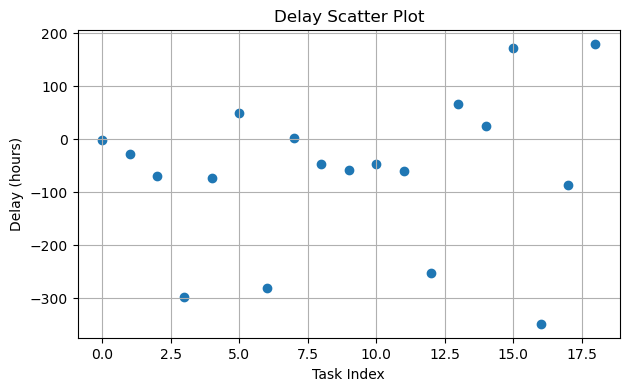

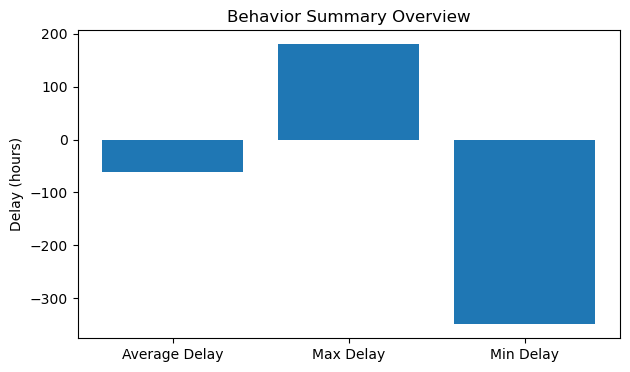

In [11]:
delays = [t.get_delay(df["due_date"].iloc[0]) for t in tasks]

viz = Visualizer(delays)

viz.plot_timeline()
viz.plot_scatter()
viz.plot_summary()


In [13]:
# Deadline Prediction (re-run this to define predicted_date)

predictor = DeadlinePredictor()

for t in tasks:
    predictor.add_delay(t.get_delay(df["due_date"].iloc[0]))

predicted_date = predictor.predict_submission_date("2025-12-30 23:59")

predicted_date



datetime.datetime(2025, 12, 28, 10, 33, 56, 842105)

In [14]:
report = ReportGenerator(df["student_id"].iloc[0])

report.add_section("Behavior", ba.get_statistics())
report.add_section("Pattern", pattern_result)
report.add_section("Predicted Next Submission", str(predicted_date))
report.add_section("Difficult Tasks", difficulty.get_difficult_tasks())
report.add_section("Habit Score", final_score)

final_report = report.generate()
final_report


{'student_id': np.int64(2024245901),
 'report': {'Behavior': {'tasks_analyzed': 19,
   'avg_delay_hours': -61.41754385964912,
   'std_dev_delay': 145.84868178212255,
   'behavior_label': 'Early Finisher'},
  'Pattern': 'Morning Worker',
  'Predicted Next Submission': '2025-12-28 10:33:56.842105',
  'Difficult Tasks': [('Data Visualization', 180.0),
   ('Machine Learning Project', 171.0),
   ('HCI PIT', 67.0)],
  'Habit Score': 100}}